In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
import scipy.special
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from dml_ate_iv import DMLATEIV

# Data Generation - TripAdvisor

- Used for generating data that looks similar in structure to the data used for the Google One-Tap test at TripAdvisor. Useful for testing the input format.
- Input rows are not necessarily internally consistent (e.g. non-0 clicks but 0 visits is possible).
- Columns names will be the same (or similar), but the values are generated from a fixed distribution that depends on the data type (e.g. integer, counts, floating point). 
- Also removed some columns that are repetitive (e.g. only include days_visited some, rather than all the different business units).

In [15]:
import numpy as np
import pandas as pd
import locale

n = 10000
##100000  # Generated dataset size
np.random.seed(123)

X_colnames = {
    'days_visited_as_pre': 'day_count_pre',  # How many days did they visit TripAdvisor attractions pages in the pre-period
    'days_visited_free_pre': 'day_count_pre',  # How many days did they visit TripAdvisor through free channels (e.g. domain direct) in the pre-period
    'days_visited_fs_pre': 'day_count_pre',  # How many days did they visit TripAdvisor fs pages in the pre-period    
    'days_visited_hs_pre': 'day_count_pre',  # How many days did they visit TripAdvisor hotels pages in the pre-period
    'days_visited_rs_pre': 'day_count_pre',  # How many days did they visit TripAdvisor restaurant pages in the pre-period
    'days_visited_vrs_pre': 'day_count_pre',  # How many days did they visit TripAdvisor vrs pages in the pre-period
    'first_visit_days': 'day_count_post',   # How many days into the experiment did they first visit
    'is_existing_member': 'binary', #Binary indicator of whether they are existing member
    'last_visit_days_pre': 'day_count_pre',  # How many days before the experiment did they last visit (if at all). 0 means they did not visit, 1 means they visited the day before the experiment etc.
    'locale': 'locale',  # User's locale
    'meta_clicks_pre': 'count',  # Meta clicks in the pre-period
    'meta_revenue_in_dollars_pre': 'revenue',  # Meta Revenue in the pre-period
    'no_visit_in_pre': 'binary',  # Binary indicator of whether they visited in the pre-period or not (if this is 1, then all pre-period values will be 0)
    'os_type': 'os',  # User's operating system
    'revenue_in_dollars_pre': 'revenue',  # Revenue in the pre-period
    'other_revenue_in_dollars_pre': 'revenue',  # Other Revenue in the pre-period
    'other_clicks_pre': 'count',  # Other clicks in the pre-period
}

treat_colnames = {
    'treatment': 'binary',  # Did they receive the Google One-Tap experiment? [This is the instrument]
    'is_member': 'is_member'  # Did they become a member during the experiment period (through any means)? [This is the treatment of interest]
}

outcome_colnames = {
    'days_visited': 'days_visited',  # How many days did they visit TripAdvisor in the experimental period
}


In [16]:
def gen_data(data_type, n):
    gen_func = {'day_count_pre': lambda: np.random.randint(0, 29 , n),  # Pre-experiment period was 28 days
                'day_count_post': lambda: np.random.randint(0, 15, n),  # Experiment ran for 14 days
                'os': lambda: np.random.choice(['osx', 'windows', 'linux'], n),
                'locale': lambda: np.random.choice(list(locale.locale_alias.keys()), n),
                'count': lambda: np.random.lognormal(1, 1, n).astype('int'),
                'binary': lambda: np.random.binomial(1, .5, size=(n,)),
                ##'days_visited': lambda: 
                'revenue': lambda: np.round(np.random.lognormal(0, 3, n), 2)
                
               }
    
    return gen_func[data_type]() if data_type else None


In [17]:
X_data = {colname: gen_data(datatype, n) for colname, datatype in X_colnames.items()}
##treat_data = {colname: gen_data(datatype, N) for colname, datatype in treat_colnames.items()}
##outcome_data = {colname: gen_data(datatype, N) for colname, datatype in outcome_colnames.items()}

In [18]:
X_data=pd.DataFrame({**X_data})
# Turn strings into categories for numeric mapping
X_data['os_type'] = X_data.os_type.astype('category').cat.codes
X_data['locale'] = X_data.locale.astype('category').cat.codes
print(X_data.columns.values)

['days_visited_as_pre' 'days_visited_free_pre' 'days_visited_fs_pre'
 'days_visited_hs_pre' 'days_visited_rs_pre' 'days_visited_vrs_pre'
 'first_visit_days' 'is_existing_member' 'last_visit_days_pre' 'locale'
 'meta_clicks_pre' 'meta_revenue_in_dollars_pre' 'no_visit_in_pre'
 'os_type' 'other_clicks_pre' 'other_revenue_in_dollars_pre'
 'revenue_in_dollars_pre']


In [19]:
X_pre=X_data.values.astype('float')

In [20]:
def dgp_binary(X,n,true_fn):
    ##X = np.random.uniform(-1, 1, size=(n, d))
    Z = np.random.binomial(1, .5, size=(n,))
    nu = np.random.uniform(0, 10, size=(n,))
    coef_Z = 0.2
    plt.title("Pr[T=1 | Z=1, X] vs Pr[T=1 | Z=0, X]")
    plt.scatter(X[:, 0], coef_Z*scipy.special.expit(0.1*(X[:, 0] + nu)))
    plt.scatter(X[:, 0], .1*np.ones(X.shape[0]))
    plt.show()
    C = np.random.binomial(1, coef_Z*scipy.special.expit(0.1*(X[:, 0] + nu))) # Compliers when recomended
    C0 = np.random.binomial(1, .006*np.ones(X.shape[0])) # Non-compliers when not recommended 
    T = C * Z + C0 * (1 - Z)
    y = true_fn(X) * (T + 0.05*nu)  + (0.1*X[:, 0] + 0.1*np.random.uniform(0, 1, size=(n,)))
    return y, T, Z
true_fn = lambda X: (.8+.5*X[:,0] - 3*X[:, 7])

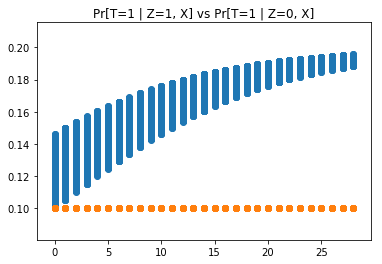

In [21]:
y, T, Z = dgp_binary(X_pre, n, true_fn)

In [22]:
X = QuantileTransformer(subsample=100000).fit_transform(X_pre)

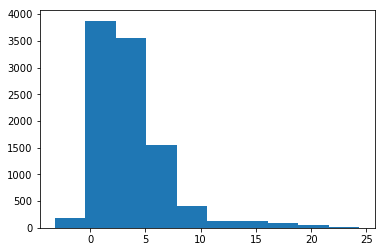

In [23]:
#### y menas number of days visit TripAdvisor in the experimental period, should be in range [0,14], 
##should be strong right skewed
plt.hist(y)
plt.show()

In [24]:
print("True ATE: {:.3f}".format(np.mean(true_fn(X_pre))))

True ATE: 6.349


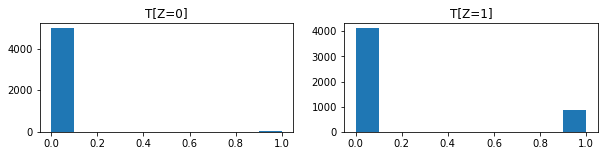

In [25]:
plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(T[Z==0])
plt.title("T[Z=0]")
plt.subplot(1, 2, 2)
plt.hist(T[Z==1])
plt.title("T[Z=1]")
plt.show()

In [26]:
print("New members: in treatment = {:f}, in control = {:f}".format(T[Z == 1].sum()/Z.sum(), T[Z == 0].sum()/(1-Z).sum()))

New members: in treatment = 0.172054, in control = 0.004184


In [27]:
print("Z treatment proportion: {:.5f}".format(np.mean(Z)))

Z treatment proportion: 0.49810


### Defining some generic regressors and classifiers

In [28]:
from dml_ate_iv import DMLATEIV
from utilities import RegWrapper
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn import metrics
from xgboost import XGBClassifier, XGBRegressor
from xgb_utilities import XGBWrapper


# Define a generic non-parametric regressor
#model = lambda: GradientBoostingRegressor(n_estimators=20, max_depth=3, min_samples_leaf=20,
#                                         n_iter_no_change=5, min_impurity_decrease=.001, tol=0.001)
model = lambda: XGBWrapper(XGBRegressor(gamma=0.001, n_estimators=50, min_child_weight=50, n_jobs=10),
                           early_stopping_rounds=5, eval_metric='rmse', binary=False)

# model = lambda: RandomForestRegressor(n_estimators=100)
# model = lambda: Lasso(alpha=0.0001) #CV(cv=5)
# model = lambda: GradientBoostingRegressor(n_estimators=60)
# model = lambda: LinearRegression(n_jobs=-1)
# model = lambda: LassoCV(cv=5, n_jobs=-1)

# Define a generic non-parametric classifier. We have to wrap it with the RegWrapper, because
# we want to use predict_proba and not predict. The RegWrapper calls predict_proba of the
# underlying model whenever predict is called.
#model_clf = lambda: RegWrapper(GradientBoostingClassifier(n_estimators=20, max_depth=3, min_samples_leaf=20,
#                                         n_iter_no_change=5, min_impurity_decrease=.001, tol=0.001))
model_clf = lambda: RegWrapper(XGBWrapper(XGBClassifier(gamma=0.001, n_estimators=50, min_child_weight=50, n_jobs=10),
                                          early_stopping_rounds=5, eval_metric='logloss', binary=True))
# model_clf = lambda: RandomForestClassifier(n_estimators=100)
# model_clf = lambda: RegWrapper(GradientBoostingClassifier(n_estimators=60))
# model_clf = lambda: RegWrapper(LogisticRegression(C=10, penalty='l1', solver='liblinear'))
# model_clf = lambda: RegWrapper(LogisticRegressionCV(n_jobs=-1, cv=3, scoring=scoring='neg_log_loss')

model_clf_dummy = lambda: RegWrapper(DummyClassifier(strategy='prior'))

# We need to specify models to be used for each of these residualizations
model_Y_X = lambda: model() # model for E[Y | X]
model_T_X = lambda: model_clf() # model for E[T | X]. We use a classifier since T is binary
model_Z_X = lambda: model_clf_dummy() # model for E[Z | X]. We use a classifier since Z is binary

# We fit DMLATEIV with these models and then we call effect() to get the ATE.
# n_splits determines the number of splits to be used for cross-fitting.

# Algorithm 2 - Current Method

In [29]:
dmlateiv_obj = DMLATEIV(model_Y_X(), model_T_X(), model_Z_X(),
                  n_splits=10, # n_splits determines the number of splits to be used for cross-fitting.
                  binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                  binary_treatment=True # a flag whether to stratify cross-fitting by treatment
                 )

dmlateiv_obj.fit(y, T, X, Z)

In [30]:
ta_effect = dmlateiv_obj.effect()
ta_effect_conf = dmlateiv_obj.normal_effect_interval(lower=5, upper=95)

print("True ATE: {:.3f}".format(np.mean(true_fn(X_pre))))
print("Estimate: {:.3f}".format(ta_effect))
print("ATE Estimate Interval: ({:.3f}, {:.3f})".format(ta_effect_conf[0], ta_effect_conf[1]))
print("ATE Estimate Std: {:.3f}".format(dmlateiv_obj.std))

True ATE: 6.349
Estimate: 6.760
ATE Estimate Interval: (6.273, 7.246)
ATE Estimate Std: 0.296


# DMLIV CATE

In [31]:
from dml_iv import DMLIV, GenericDMLIV
from utilities import SelectiveLasso, SeparateModel
from sklearn.linear_model import LassoCV
from econml.utilities import hstack

np.random.seed(123)

# For DMLIV we also need a model for E[T | X, Z]. We use a classifier since T is binary
# Because Z is also binary, we could have also done a more complex model_T_XZ, where we split
# the data based on Z=1 and Z=0 and fit a separate sub-model for each case.
model_T_XZ = lambda: SeparateModel(model_clf(), model_clf())

# We now specify the features to be used for heterogeneity. We will fit a CATE model of the form
#      theta(X) = <theta, phi(X)>
# for some set of features phi(X). The featurizer needs to support fit_transform, that takes
# X and returns phi(X). We need to include a bias if we also want a constant term.
dmliv_featurizer = lambda: PolynomialFeatures(degree=1, include_bias=True)

# Then we need to specify a model to be used for fitting the parameters theta in the linear form.
# This model will minimize the square loss:
#        (Y - E[Y|X] - <theta, phi(X)> * (E[T|X,Z] - E[T|X]))**2
# potentially with some regularization on theta. Here we use an ell_1 penalty on theta
# dmliv_model_effect = lambda: LinearRegression()

# We could also use LassoCV to select the regularization weight in the final stage with
# cross validation.
# dmliv_model_effect = lambda: LassoCV(fit_intercept=False, cv=3)

# If we also have a prior that there is no effect heterogeneity we can use a selective lasso
# that does not penalize the constant term in the CATE model
feature_inds = np.arange(1, X.shape[1]+1)
dmliv_model_effect = lambda: SelectiveLasso(feature_inds, LassoCV(cv=5, n_jobs=-1))

cate = DMLIV(model_Y_X(), model_T_X(), model_T_XZ(), 
             dmliv_model_effect(), dmliv_featurizer(),
             n_splits=10, # number of splits to use for cross-fitting
             binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
             binary_treatment=True # a flag whether to stratify cross-fitting by treatment
            )
"""
dmliv_model_effect = lambda: model()
cate = GenericDMLIV(model_Y_X(), model_T_X(), model_T_XZ(), 
             dmliv_model_effect(),
             n_splits=10, # number of splits to use for cross-fitting
             binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
             binary_treatment=True # a flag whether to stratify cross-fitting by treatment
            )"""

'\ndmliv_model_effect = lambda: model()\ncate = GenericDMLIV(model_Y_X(), model_T_X(), model_T_XZ(), \n             dmliv_model_effect(),\n             n_splits=10, # number of splits to use for cross-fitting\n             binary_instrument=True, # a flag whether to stratify cross-fitting by instrument\n             binary_treatment=True # a flag whether to stratify cross-fitting by treatment\n            )'

In [32]:
%%time
cate.fit(y, T, X, Z, store_final=True)

Wall time: 2.92 s


In [33]:
dmliv_effect = cate.effect(X)

In [34]:
# We can average the CATE to get an ATE
print("ATE Estimate: {:.3f}".format(np.mean(dmliv_effect)))
print("True ATE: {:.3f}".format(np.mean(true_fn(X_pre))))

ATE Estimate: 5.953
True ATE: 6.349


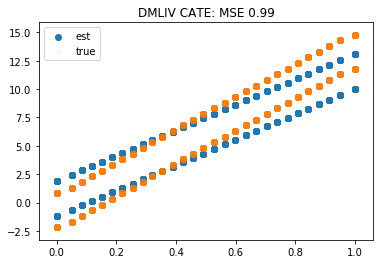

In [35]:
# We can also see how it compares to the true CATE at each target point and calculate MSE
plt.title("DMLIV CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - dmliv_effect)**2)))
plt.scatter(X[:, 0], dmliv_effect, label='est')
plt.scatter(X[:, 0], true_fn(X_pre), label='true', alpha=.05)
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


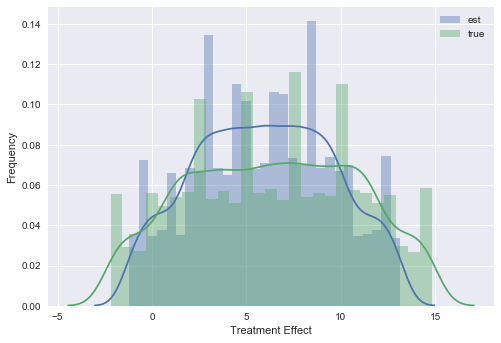

In [36]:
##histogram of estimated treatment effect
import seaborn as sns

sns.distplot(dmliv_effect, label='est')
sns.distplot(true_fn(X_pre), label='true')
plt.legend()
plt.xlabel("Treatment Effect")
plt.ylabel("Frequency")
plt.show()

# Algorithm 3 - DRIV ATE

In [37]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper, StatsModelLinearRegression, ConstantModel

np.random.seed(123)

# For DRIV we need a model for predicting E[T*Z | X]. We use a classifier
model_TZ_X = lambda: model_clf()

# We also need a model for the final regression that will fit the function theta(X)
# If we want to fit an ATE, we simply fit a constant functin theta(X) = theta
# We can do this with a pipeline where the preprocessing step only creates a bias column
# and the regression step fits a linear regression with no intercept.
# To get normal confidence intervals easily we can use a statsmodels linear regression
# wrapped in an sklearn interface
driv_model_effect = lambda: ConstantModel()

# As in OrthoDMLIV we need a perliminary estimator of the CATE.
# We use a DMLIV estimator with no cross-fitting (n_splits=1)
dmliv_featurizer = lambda: PolynomialFeatures(degree=1, include_bias=True)
dmliv_model_effect = lambda: SelectiveLasso(np.arange(1, X.shape[1]+1), LassoCV(cv=5, n_jobs=-1))
prel_model_effect = DMLIV(model_Y_X(), model_T_X(), model_T_XZ(),
                          dmliv_model_effect(), dmliv_featurizer(), n_splits=1)

dr_cate = DRIV(model_Y_X(), model_T_X(), model_Z_X(), # same as in DMLATEIV
                        prel_model_effect, # preliminary model for CATE, must support fit(y, T, X, Z) and effect(X)
                        model_TZ_X(), # model for E[T * Z | X]
                        driv_model_effect(), # model for final stage of fitting theta(X)
                        cov_clip=.0001, # covariance clipping to avoid large values in final regression from weak instruments
                        n_splits=10, # number of splits to use for cross-fitting
                        binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                        binary_treatment=True, # a flag whether to stratify cross-fitting by treatment
                        opt_reweighted=False
                       )

In [38]:
%%time
dr_cate.fit(y, T, X, Z, store_final=True)

Wall time: 7.35 s


In [39]:
dr_cate.effect_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Sat, 01 Jun 2019   Prob (F-statistic):                nan
Time:                        17:10:31   Log-Likelihood:                -40711.
No. Observations:               10000   AIC:                         8.142e+04
Df Residuals:                    9999   BIC:                         8.143e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4223      0.142     45.275      0.000       6.144       6.700
==============================================================================
Omnibus:                     1042.062   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1857.997
Skew:                           0.715   Prob(JB):                         0.00
Kurtosis:                       4.554   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
lr = LinearRegression().fit(X, true_fn(X_pre))
print(lr.coef_)
print(lr.intercept_)

[ 1.43606542e+01  1.72844438e-04 -1.35004027e-03  2.38066059e-03
 -1.53427538e-03 -2.54768666e-03 -7.78231415e-04 -2.99957950e+00
 -1.30513776e-03  2.30108992e-03  7.66579764e-04  3.18558782e-03
  1.95876969e-04 -1.95763079e-03 -3.49148972e-03  2.72254163e-03
 -1.78837573e-03]
0.6791528319942115


## Projecting to subset

In [41]:
from utilities import WeightWrapper
subset_names = X_data.columns.values
#subset_names = set(['days_visited_as_pre', 'is_existing_member'])
# list of indices of features X to use in the final model
feature_inds = np.argwhere([(x in subset_names) for x in X_data.columns.values]).flatten()
print(feature_inds)
# Because we are projecting to a low dimensional model space, we can
# do valid inference and we can use statsmodel linear regression to get all
# the hypothesis testing capability
lr_driv_model_effect = lambda: SubsetWrapper(StatsModelLinearRegression(),
                                          feature_inds # list of indices of features X to use in the final model
                                         )
dr_cate.refit_final(lr_driv_model_effect())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [42]:
driv_cate = dr_cate.effect(X[:, feature_inds])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


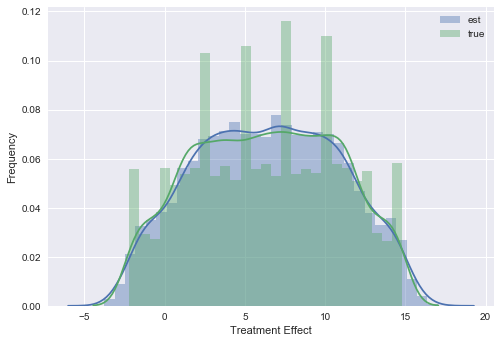

In [43]:
##histogram of estimated treatment effect
import seaborn as sns

sns.distplot(driv_cate, label='est')
sns.distplot(true_fn(X_pre), label='true')
plt.legend()
plt.xlabel("Treatment Effect")
plt.ylabel("Frequency")
plt.show()

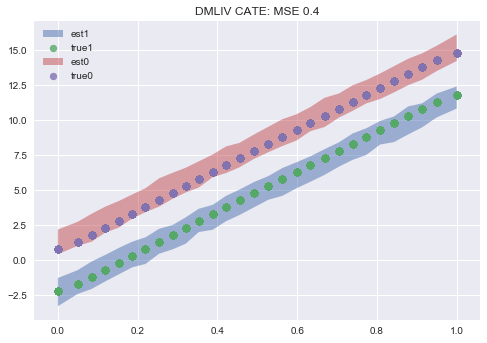

In [44]:
# We can also see how it compares to the true CATE at each target point and calculate MSE
plt.title("DMLIV CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - driv_cate)**2)))
ones = X[:, 7]>.5
lower = []
upper = []
unique_X = np.unique(X[ones, 0])
for t in unique_X:
    upper.append(np.percentile(driv_cate[ones & (X[:, 0]==t)], 95))
    lower.append(np.percentile(driv_cate[ones & (X[:, 0]==t)], 5))
plt.fill_between(unique_X, lower, upper, label='est1', alpha=.5)
plt.scatter(X[ones, 0], true_fn(X_pre[ones]), label='true1', alpha=.8)
ones = X[:, 7]<.5
lower = []
upper = []
unique_X = np.unique(X[ones, 0])
for t in unique_X:
    upper.append(np.percentile(driv_cate[ones & (X[:, 0]==t)], 95))
    lower.append(np.percentile(driv_cate[ones & (X[:, 0]==t)], 5))
plt.fill_between(unique_X, lower, upper, label='est0', alpha=.5)
plt.scatter(X[ones, 0], true_fn(X_pre[ones]), label='true0', alpha=.8)
plt.legend()
plt.show()

In [45]:
# To get the ATE we look at the params of the fitted statsmodel
dr_effect = np.mean(driv_cate)
dr_effect

6.4222979902179596

In [46]:
# To get the statsmodel summary we look at the effect_model, which is the pipeline, we then look
# at the reg step of the pipeline which is the statsmodel wrapper and then we look
# at the model attribute of the statsmodel wrapper and print the summary()
dr_cate.effect_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     64.33
Date:                Sat, 01 Jun 2019   Prob (F-statistic):          5.03e-210
Time:                        17:10:33   Log-Likelihood:                -40191.
No. Observations:               10000   AIC:                         8.042e+04
Df Residuals:                    9982   BIC:                         8.055e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6993      0.915      0.764      0.445      -1.095       2.493
x1            13.9045      0.465     29.904      0.000      12.993      14.816
x2             0.3134      0.464      0.676      0.499      -0.596       1.223
x3             1.1020      0.464      2.374      0.018       0.192       2.012
x4            -0.5954      0.464     -1.283      0.200      -1.505       0.314
x5            -0.5077      0.464     -1.094      0.274      -1.418       0.402
x6            -0.4408      0.464     -0.949      0.343      -1.351       0.470
x7             0.3649      0.457      0.798      0.425      -0.531       1.261
x8            -3.5070      0.270    -12.994      0.000      -4.036      -2.978
x9            -0.2875      0.464     -0.619      0.536      -1.197       0.622
x10            0.1685      0.467      0.361      0.718      -0.748       1.085
x11            0.4804      0.443      1.085      0.278      -0.387       1.348
x12           -0.3968      0.465     -0.853      0.394      -1.309       0.515
x13            0.2616      0.270      0.970      0.332      -0.267       0.790
x14           -0.4032      0.331     -1.220      0.223      -1.051       0.245
x15            0.0963      0.443      0.217      0.828      -0.772       0.965
x16            0.3984      0.465      0.856      0.392      -0.514       1.310
x17            0.5303      0.465      1.141      0.254      -0.381       1.442
==============================================================================
Omnibus:                      380.249   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1172.480
Skew:                          -0.016   Prob(JB):                    2.51e-255
Kurtosis:                       4.677   Cond. No.                         17.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
print("ATE Estimate: {:.2f}".format(dr_effect))
print("True ATE: {:.2f}".format(np.mean(true_fn(X_pre))))

ATE Estimate: 6.42
True ATE: 6.35


In [48]:
lr = LinearRegression().fit(X[:, feature_inds], true_fn(X_pre).reshape(-1, 1))
print(lr.coef_)
print(lr.intercept_)

[[ 1.43606542e+01  1.72844438e-04 -1.35004027e-03  2.38066059e-03
  -1.53427538e-03 -2.54768666e-03 -7.78231415e-04 -2.99957950e+00
  -1.30513776e-03  2.30108992e-03  7.66579764e-04  3.18558782e-03
   1.95876969e-04 -1.95763079e-03 -3.49148972e-03  2.72254163e-03
  -1.78837573e-03]]
[0.67915283]


Coverage of True Projection: 0.93


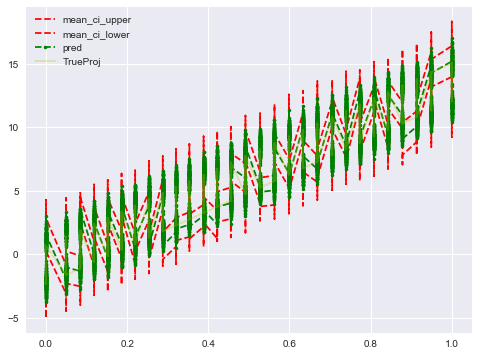

In [49]:
# We can also evaluate coverage and create prediction intervals using statsmodels attributes
from statsmodels.sandbox.regression.predstd import wls_prediction_std
res = dr_cate.effect_model.model
predictions = res.get_prediction(PolynomialFeatures(degree=1, include_bias=True).fit_transform(X[:, feature_inds]))
frame = predictions.summary_frame(alpha=0.05)
pred = frame['mean']
iv_l = frame['mean_ci_lower']
iv_u = frame['mean_ci_upper']

# This is the true CATE functions
theta_true = true_fn(X_pre)
# This is the true projection of the CATE function on the subspace of linear functions of the
# subset of the features used in the projection
true_proj = LinearRegression().fit(X[:, feature_inds], theta_true).predict(X[:, feature_inds])

# Are we covering the true projection
covered = (true_proj <= iv_u) & (true_proj >= iv_l)
print("Coverage of True Projection: {:.2f}".format(np.mean(covered)))

fig, ax = plt.subplots(figsize=(8,6))

order = np.argsort(X[:, feature_inds[0]])
ax.plot(X[order, feature_inds[0]], iv_u[order], 'r--')
ax.plot(X[order, feature_inds[0]], iv_l[order], 'r--')
ax.plot(X[order, feature_inds[0]], pred[order], 'g--.', label="pred")
#ax.plot(X[order, feature_inds[0]], theta_true[order], 'b-', label="True", alpha=.3)
ax.plot(X[order, feature_inds[0]], true_proj[order], 'y-', label="TrueProj", alpha=.3)
ax.legend(loc='best')
plt.show()

# Random Forest Based CATE and Tree Explainer

In [50]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

np.random.seed(123)

# We need a model for the final regression that will fit the function theta(X)
# Now we use a linear model and a lasso.
rf_driv_model_effect = lambda: RandomForestRegressor(n_estimators=100, max_depth=3, min_impurity_decrease=0.1,
                                                     min_samples_leaf=500, bootstrap=True)

In [51]:
rf_dr_cate = dr_cate.refit_final(rf_driv_model_effect())

In [52]:
rf_dr_effect = rf_dr_cate.effect(X)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


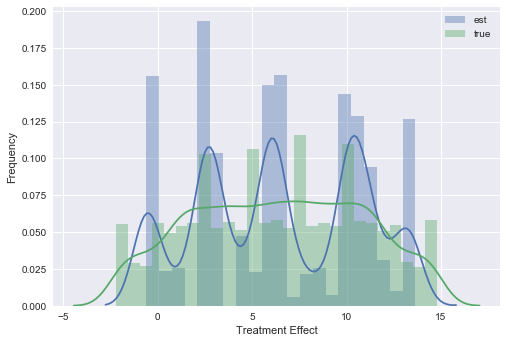

In [53]:
##histogram of estimated treatment effect
import seaborn as sns

sns.distplot(rf_dr_effect, label='est')
sns.distplot(true_fn(X_pre), label='true')
plt.legend()
plt.xlabel("Treatment Effect")
plt.ylabel("Frequency")
plt.show()

In [54]:
print("ATE Estimate: {:.2f}".format(np.mean(rf_dr_effect)))
print("True ATE: {:.2f}".format(np.mean(true_fn(X_pre))))

ATE Estimate: 6.43
True ATE: 6.35


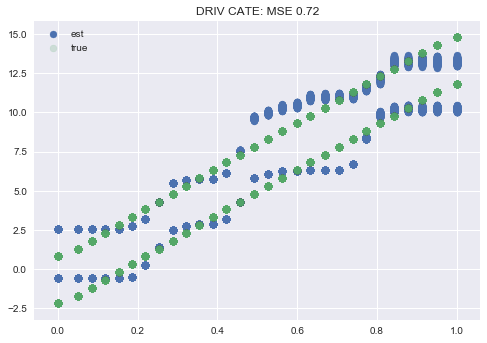

In [55]:
plt.title("DRIV CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - rf_dr_effect)**2)))
plt.scatter(X[:, 0], rf_dr_effect, label='est')
plt.scatter(X[:, 0], true_fn(X_pre), label='true', alpha=.2)
plt.legend()
plt.show()

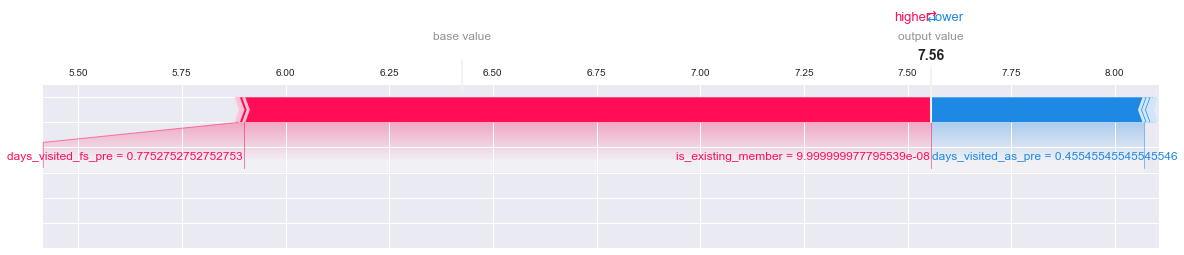

In [56]:
import shap
import pandas as pd

Xdf = pd.DataFrame(X, columns=X_data.columns)
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rf_dr_cate.effect_model)
shap_values = explainer.shap_values(Xdf)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xdf.iloc[0,:], matplotlib=True)

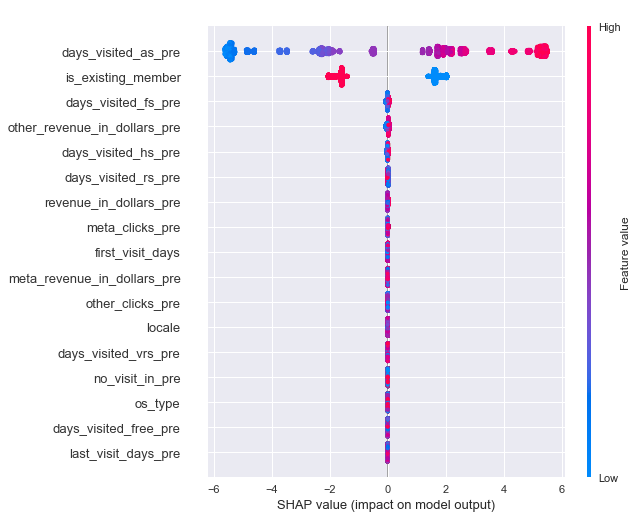

In [57]:
shap.summary_plot(shap_values, Xdf)

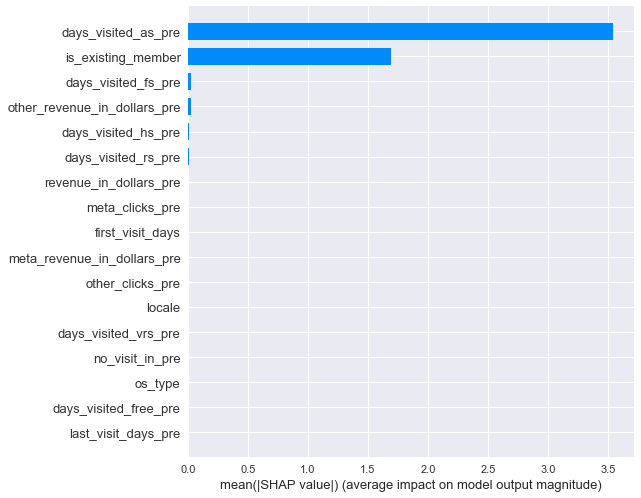

In [58]:
shap.summary_plot(shap_values, Xdf, plot_type='bar')

# CATE  with DRIV-RW

In [59]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper, StatsModelLinearRegression, ConstantModel

np.random.seed(123)

# For DRIV we need a model for predicting E[T*Z | X]. We use a classifier
model_TZ_X = lambda: model_clf()

# We also need a model for the final regression that will fit the function theta(X)
# If we want to fit an ATE, we simply fit a constant functin theta(X) = theta
# We can do this with a pipeline where the preprocessing step only creates a bias column
# and the regression step fits a linear regression with no intercept.
# To get normal confidence intervals easily we can use a statsmodels linear regression
# wrapped in an sklearn interface
rf_driv_model_effect = lambda: RandomForestRegressor(n_estimators=100, max_depth=3, min_impurity_decrease=0.001,
                                                     min_samples_leaf=500, bootstrap=True)
# As in OrthoDMLIV we need a perliminary estimator of the CATE.
# We use a DMLIV estimator with no cross-fitting (n_splits=1)
dmliv_featurizer = lambda: PolynomialFeatures(degree=1, include_bias=True)
dmliv_model_effect = lambda: SelectiveLasso(np.arange(1, X.shape[1]+1), LassoCV(cv=5, n_jobs=-1))
prel_model_effect = DMLIV(model_Y_X(), model_T_X(), model_T_XZ(),
                          dmliv_model_effect(), dmliv_featurizer(), n_splits=1)

rf_dr_cate = DRIV(model_Y_X(), model_T_X(), model_Z_X(), # same as in DMLATEIV
                        prel_model_effect, # preliminary model for CATE, must support fit(y, T, X, Z) and effect(X)
                        model_TZ_X(), # model for E[T * Z | X]
                        rf_driv_model_effect(), # model for final stage of fitting theta(X)
                        cov_clip=.0001, # covariance clipping to avoid large values in final regression from weak instruments
                        n_splits=10, # number of splits to use for cross-fitting
                        binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                        binary_treatment=True, # a flag whether to stratify cross-fitting by treatment
                        opt_reweighted=True
                       )

In [60]:
%%time
rf_dr_cate.fit(y, T, X, Z, store_final=True)

Wall time: 8.35 s


In [61]:
rf_dr_effect = rf_dr_cate.effect(X)

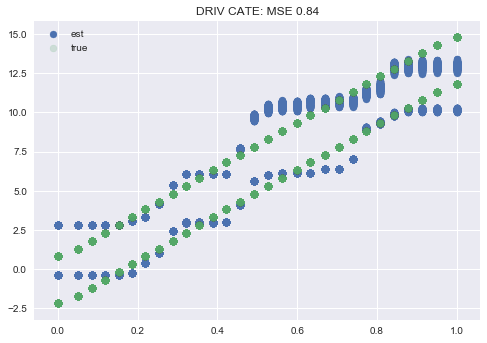

In [62]:
plt.title("DRIV CATE: MSE {:.2}".format(np.mean((true_fn(X_pre) - rf_dr_effect)**2)))
plt.scatter(X[:, 0], rf_dr_effect, label='est')
plt.scatter(X[:, 0], true_fn(X_pre), label='true', alpha=.2)
plt.legend()
plt.show()

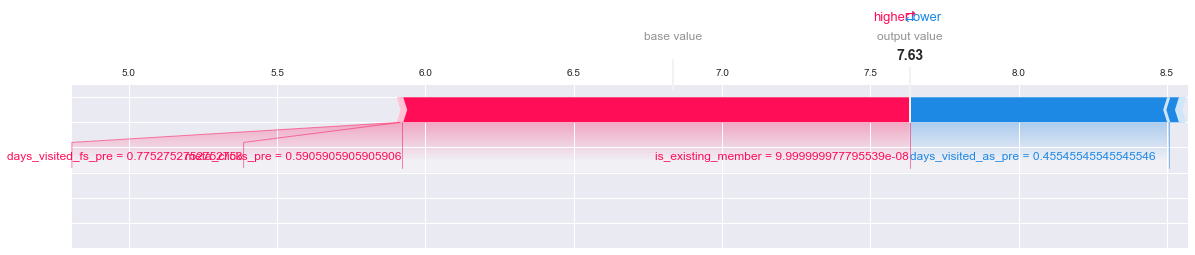

In [63]:
import shap
import pandas as pd

Xdf = pd.DataFrame(X, columns=X_data.columns)
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rf_dr_cate.effect_model)
shap_values = explainer.shap_values(Xdf)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xdf.iloc[0,:], matplotlib=True)

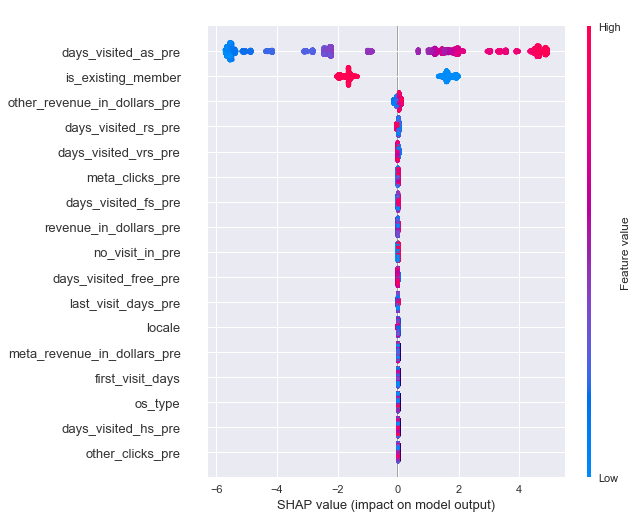

In [64]:
shap.summary_plot(shap_values, Xdf)

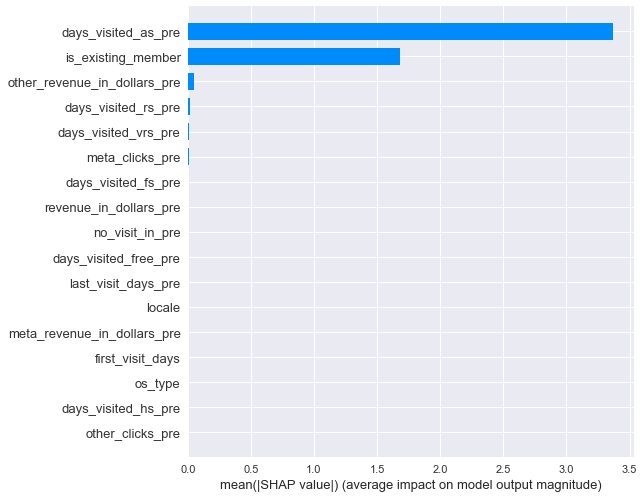

In [65]:
shap.summary_plot(shap_values, Xdf, plot_type='bar')